# IF240 - Apprentissage et deep learning

## Assignment 1: K-Means, Naive Bayes, SVMs and CNNs

### Objectives 

The objective of this assignment is to apply different classification algorithms for the application of handwritten digits recognition.

# PART 0 - Preparing the dataset

In this practice, you will experiment with the well-known MNIST dataset

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import MNISTtools

Let us first load and normalize MNIST testing and training data. This dataset is made of 60000 grayscale images of size 28$\times$28

In [126]:
x_train, y_train = MNISTtools.load(dataset='training')
x_test, y_test = MNISTtools.load(dataset='testing')
print(np.mean(x_train))
print(np.std(x_train))
#MNISTtools.show(x_train[:,0])
#print(y_train[0])

33.318421449829934
78.56748998339798


To reduce the computation cost, we only select a small part of $n$ images for further analysis. _You might modify this value later to visualise its influence on the results._

In [8]:
n = 5000
x_train = x_train[:,1:n+1]
y_train = y_train[1:n+1]

## Question 1

How many training and testing images compose the dataset? What are the dimensions of the data samples?

- Training DataSet size 4999 <br>
- Testing DataSet size 10000 <br>
- Data sample dimension 784 (vector) = 28 x 28 (matrix)

In [127]:
print(x_train.shape)
print(x_test.shape)

(784, 60000)
(784, 10000)


To visualize the images, the vectors must be reshaped to a grayscale square image.  

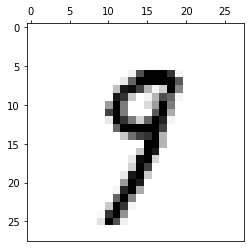

the label of image 42 is 9


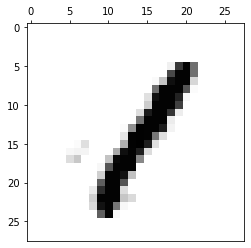

the label of image 200 is 1


In [11]:
x_test_im = x_test.reshape((28, 28, 1, -1))

x_train_im = x_train.reshape((28, 28, 1, -1))

# let us show image number 42 and its label
MNISTtools.show(x_train_im[:, :, 0, 42])
print("the label of image 42 is", y_train[42])

# let us show image number 200 and its label
MNISTtools.show(x_train_im[:, :, 0, 200])
print("the label of image 200 is", y_train[200])

# PART 1 - K-Means

In this first part you must group the testing set into 10 clusters using the K-Means algorithm. 
You must observe the clustering result by visualizing as images the computed centroids and by checking if each found cluster corresponds to one label from the ground truth given by `y_test`. In other words, check to which cluster is assigned each data point, as in a classification problem. Analyse the results. 

Be careful: the index of the clusters you find (named `pred_labels` here) does not mandatorily correspond to the digit value (initial label `y_test`). One way to find which label corresponds to each cluster is to visualise the centroid image, or to compute the mode of each class in the ground truth, for example using the following code:

```
from scipy.stats import mode
real_pred_labels = np.zeros_like(pred_labels)
real_pred_centers = np.zeros_like(pred_centers)
for i in range(10):
    indices = np.where(pred_labels == i)[0]
    real_value = mode(y_test[indices])[0]
    real_pred_labels[indices] = real_value
    real_pred_centers[real_value] = pred_centers[i]
```

In [128]:
# Transpose data, necessary for K-Means, Naive Bayes and SVM with sklearn
x_test_t =  np.transpose(x_test)
x_train_t =  np.transpose(x_train)

## Question 2

Implement K-Means. Add comments to your code as necessary to make it more explicit

In [200]:
class Kmeans(object):
    
    def __init__(self):
        self.centroids = None
        self.labels = None
        
    # Function: getDistance
    # -------------
    # Returns the distance between two points
    def getDistance(self, point1, point2):
        return np.linalg.norm(point1-point2)


    # Function: getRandomCentroids
    # -------------
    # Initialize centroids by choosing randomly k points from the dataset
    def getRandomCentroids(self, dataSet, numClusters):
        numPoints, _ = dataSet.shape
        centroids = dataSet[np.random.randint(numPoints, size =  numClusters), :]
        return centroids


    # Function: shouldStop
    # -------------
    # Returns True or False if k-means if the maximum number of iterations is reached 
    # or if the centroids do not change anymore
    def shouldStop(self, oldCentroids, centroids, iterations, MAX_ITERATIONS, UNTIL_CONV=False):
        if ((not UNTIL_CONV) and iterations > MAX_ITERATIONS): 
            return True
        return np.array_equal(oldCentroids, centroids)


    # Function: getLabels
    # -------------
    # Returns the label for each point in the dataSet. The label is the one of the closest centroid
    def getLabels(self, dataSet, centroids):
        numPoints, _ = dataSet.shape
        labels = np.zeros(numPoints)

        for i in range(numPoints) : 
            labels[i] = np.argmin([getDistance(dataSet[i], c) for c in centroids])

        return labels


    # Function: getCentroids
    # -------------
    # Returns the centroids of the clusters. Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    def getCentroids(self, dataSet, labels, k):
        newCentroids = []
        uniqueCentroids = np.unique(labels)

        for c in uniqueCentroids:
            indexs = np.where(labels == c)
            newCentroid = np.mean([dataSet[i] for i in indexs], axis=1)
            newCentroids.append(newCentroid[0])

        resulted_k = len(newCentroids)
        if (resulted_k < k):
            numPoints, _ = dataSet.shape
            np.append(newCentroids, dataSet[np.random.randint(numPoints, size =  k - resulted_k), :])

        return np.array(newCentroids)


    # Function: fit
    # -------------
    # Runs KMeans clustering
    def fit(self, dataSet, k, MAX_ITERATIONS=5, UNTIL_CONV=False):

        centroids = self.getRandomCentroids(dataSet, k)
        iterations = 0
        oldCentroids = None

        while not self.shouldStop(oldCentroids, centroids, iterations, MAX_ITERATIONS, UNTIL_CONV):
            oldCentroids = centroids
            iterations += 1
            labels = getLabels(dataSet, centroids)
            centroids = getCentroids(dataSet, labels, k)
        
        self.centroids = centroids
        self.labels = labels
        return centroids, labels
    
    def predict(self, x):
        min_dis = float('inf')
        for label in range(10):
            distance = np.linalg.norm(self.centroids[label] - x)
            if distance < min_dis:
                min_dis = distance
                predicted_label = label
        return predicted_label
    
    def evaluate_accuracy(self, x, y, centroids_labels, ISTEST=False):
        total_acc = 0
        for digit in range(10):
            tab = np.zeros(len(self.centroids))
            for i in range(y.size):
                if(y[i] == digit):
                    if (ISTEST):
                        tab[centroids_labels[self.predict(x[i])]] += 1
                    else:
                        tab[centroids_labels[int(self.labels[i])]] += 1
            digit_acc = max(tab) / sum(tab) * 100.0
            total_acc += digit_acc
        print("KMeans Accuracy " + str(total_acc / 10))

## Question 3

Analyse the results

In [210]:
KM = Kmeans()
centroids, labels = KM.fit(x_train_t, 10, UNTIL_CONV=True)

In [218]:
def show_centroids(centroids):
    for i in range(len(centroids)):
        result_imag = centroids[i].T.reshape((28, 28, 1, -1))
        MNISTtools.show(result_imag[:, :, 0, 0])

In [212]:
def pourcentage_train_tab(x_train, y_train, centroids, labels, SHOW=True):
    tab = np.zeros((len(centroids), len(centroids)))
    for i in range(y_train.size):
        tab[y_train[i], int(labels[i])] += 1
    row_sums = tab.sum(axis=1)
    row_max_ind = tab.argmax(axis=0)
    tab = tab / row_sums[:np.newaxis] * 100
    row_sums = tab.sum(axis=1)
    if (SHOW):
        plt.imshow(tab)
        plt.colorbar()
    return row_max_ind

In [213]:
def pourcentage_test_tab(x_test, y_test, KM_instance, centroids, SHOW=True):
    labels = np.array([KM_instance.predict(x) for x in x_test])
    tab = np.zeros((len(centroids), len(centroids)))
    for i in range(y_test.size):
        tab[y_test[i], int(labels[i])] += 1
    row_sums = tab.sum(axis=1)
    row_max_ind = tab.argmax(axis=0)
    tab = tab / row_sums[:np.newaxis] * 100
    row_sums = tab.sum(axis=1)
    if (SHOW):
        plt.imshow(tab)
        plt.colorbar()
    return row_max_ind

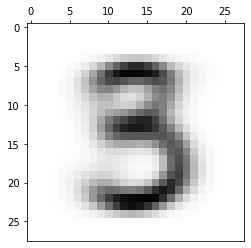

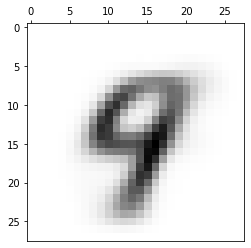

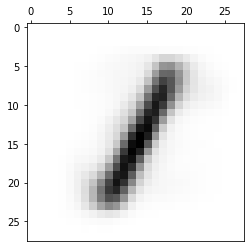

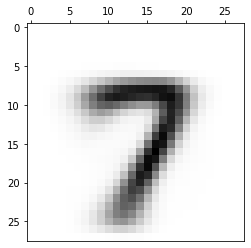

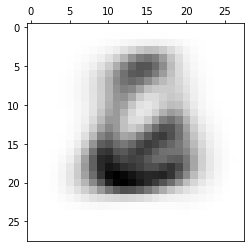

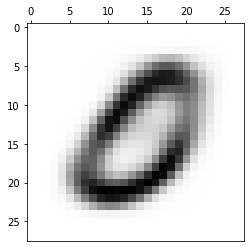

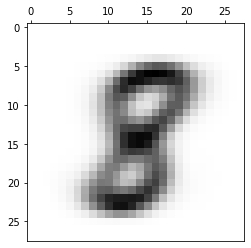

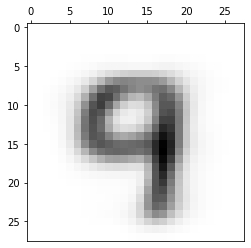

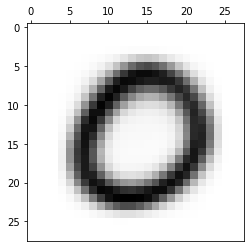

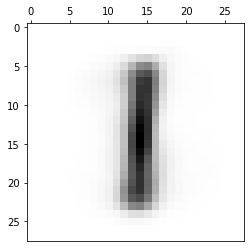

In [219]:
show_centroids(centroids)

[3 9 1 7 6 0 8 4 0 1]


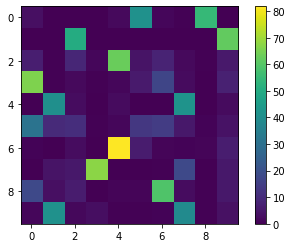

In [214]:
centroids_labels = pourcentage_train_tab(x_train, y_train, centroids, labels)
print(centroids_labels)

[3 4 1 7 6 0 8 4 0 1]


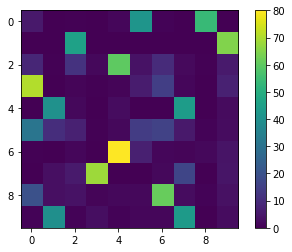

In [215]:
test_centroids_labels = pourcentage_test_tab(x_test_t, y_test, KM, centroids)
print(test_centroids_labels)

In [216]:
KM.evaluate_accuracy(x_train_t, y_train, centroids_labels)
KM.evaluate_accuracy(x_test_t, y_test, centroids_labels, True)

KMeans Accuracy 65.16312114653849
KMeans Accuracy 65.25442596562526


*COMPLETE*

# PART 2 - Naive Bayes
Apply Naive Bayes classification to the digits classification problem. Train the model on the training dataset and evaluate on the testing set. Analyse your results

## Question 4

Implement Naive Bayes. Add comments to your code as necessary to make it more explicit

In [ ]:
# COMPLETE

## Question 5

Analyse the results obtained on the testing dataset 

In [ ]:
# COMPLETE

*COMPLETE*

# PART 3 - SVM
Apply SVM classification with linear and polynomial/gaussian kernels to the digits classification problem. Train the models on the training dataset and evaluate on the testing set. Analyse your results

## Question 6

Implement SVM classification with linear and polynomial/gaussian kernels. Add comments to your code as necessary to make it more explicit

In [ ]:
# COMPLETE

## Question 7

Analyse the results obtained on the testing dataset

In [ ]:
# COMPLETE

*COMPLETE*

# PART 4 - CNNs

CNNs are specific artificial neural networks composed of *convolutional* layers, *maxpooling* operations, and
*fully connected* layers.
- Convolutional layers are like typical layers where the weight matrix has a specific structure that is relevant for signals and images.  
They take as input $N$ images and produce as output $C$ images (called *feature maps* or *channels*).   
They are parameterized by a collection of coeficients that defines a filter bank. Each filter performs a weighted average of its inputs within local sliding windows of size $K \times K$  (pixels) where $K$ is a hyperparameter (a small odd number: 3, 5, 7, 9).  
As for classical layers in neural networks, each feature map is next processed by an activation function such as  ReLU.  
    
- Maxpooling operations reduce the dimensions of the feature maps by picking the maximum value within local but non-overlapping sliding windows of size $L \times L$ (pixels) where $L$ is another hyper-parameter (usually 2). Maxpooling does not introduce new parameters to be learned.  
  
- Fully connected layers are standard layers where the weight matrix does not have a specific structure: each of the $N$ output units is connected to each of the $M$ input units.

## Question 8

PyTorch expects that the input of a convolutional layer is stored in the following format:
  $$
  \texttt{Batch size} \times \texttt{Number of input channels} \times \texttt{Image height} \times \texttt{Image width}
  $$
  
The number of input channels in our case is 1 because MNIST is composed of grayscale images. It would have been 3 if the images were in RGB color.
In deeper layers, the number of input channels will be the number of feature maps coming from the previous layer.

Reorganise the tensors `x_train_im` and `x_test_im` accordingly.
Hint:
  Reshape them first with shape $\texttt{(28, 28, 1, 60000)}$ and $\texttt{(28, 28, 1, 10000)}$
  respectively and then use `np.moveaxis`.

In [8]:
x_train_im = np.moveaxis(x_train_im, [0, 1, 2], [-1, -2, -3])
x_test_im = np.moveaxis(x_test_im, [0, 1, 2], [-1, -2, -3])

Let us also normalize MNIST testing and training data.

In [9]:
def normalize_MNIST_images(x):
    return 2 * x.astype(np.float32) / 255. - 1
x_train_im = normalize_MNIST_images(x_train_im)
x_test_im = normalize_MNIST_images(x_test_im)

and finally wrap all the data into torch Tensors

In [10]:
x_train_torch = torch.from_numpy(x_train_im)
y_train_torch = torch.from_numpy(y_train)
x_test_torch = torch.from_numpy(x_test_im)
y_test_torch = torch.from_numpy(y_test)

## Question 9

Neural networks can be constructed using the `torch.nn` package, which relies on `autograd` differentiation tools.
This package provides an implementation of CNNs as follows:

* Convolutional layers can be created as `nn.Conv2d(N, C, K)`.
  For input images of size $W \times H$, without padding the output feature maps have size $[W-K+1] \times [H-K+1]$.
* In PyTorch, maxpooling is implemented like any other non-linear function (such as
  `ReLU` or `softmax`).
  For input images of size $W \times H$, the output feature maps
  have size $\lceil W/L \rceil \times \lceil H/L \rceil$.
* A fully connected layer can be created as `nn.Linear(M, N)`.

Our LeNet network will be composed successively of
   1. a convolutional layer (i) connecting the input image to 6
    feature maps with $5 \times 5$ convolutions ($K = 5$) and followed
    by ReLU and maxpooling (ii) ($L=2$),
   2. a convolutional layer (iii) connecting the 6 input channels to 16
    output channels with $5 \times 5$ convolutions and followed
    by ReLU and maxpooling (iv) ($L=2$),
   3. a fully-connected layer connecting $16$ feature maps
    to $120$ output units and followed by ReLU,
   4. a fully-connected layer connecting $120$ inputs
    to $84$ output units and followed by ReLU,
   5. a final linear layer connecting $84$ inputs
    to $10$ linear outputs (one for each of our digits).

Determine the size of the feature maps after each convolution and maxpooling operation i.e. at points (i)-(iv) processing steps. 

Lets consider one sample of size $28 \times 28$.

$(i)$ Applying $6$ filters of size $5 \times 5$ with no padding and a stride of one would give us $6$ feature maps of size $24 \times 24$ (taking into account the bias, this corresponds to $156$ parameters). 

$(ii)$ Following the maxpooling, each of the 6 feature maps will be reduced to $12 \times 12$.

$(iii)$ Considering a stride of one and no padding, we will obtain $16$ feature map each of size $8 \times 8$ (this layer has $416$ parameters).

$(iv)$ Following the maxpooling, each of the 16 feature maps will be reduced to $4 \times 4$.

## Question 10

Analyse and complete the following code initializing our LeNet network. 

Note that you just have to define the forward function, and the backward function (where gradients are computed) will be automatically defined for you using `autograd`.
You can use any of the Torch tensor operations in the forward function.
For more details, please refer to https://pytorch.org/docs/stable/nn.html

In [11]:
# The neural networks class
class LeNet(nn.Module):

    # define our network structure
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6 , 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # define one forward pass through the network
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # helper function to understand the dimensions
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        return np.prod(size)

net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Question 11

Run the following and interpret the results. What are the learnable parameters?  Are gradients going to be tracked for all parameters?

In [12]:
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)  

conv1.weight torch.Size([6, 1, 5, 5]) True
conv1.bias torch.Size([6]) True
conv2.weight torch.Size([16, 6, 5, 5]) True
conv2.bias torch.Size([16]) True
fc1.weight torch.Size([120, 256]) True
fc1.bias torch.Size([120]) True
fc2.weight torch.Size([84, 120]) True
fc2.bias torch.Size([84]) True
fc3.weight torch.Size([10, 84]) True
fc3.bias torch.Size([10]) True


This shows that the learnable parameters (weights and biases) of each layer.

We can see that the gradients are going to be tracked for all parameters (**todo** elaborate here on why that is necessary for backprop).

**Remark:** Although the size of the weight tensor in the second convolutional layer is $16\times 6\times 5\times 5$ the real number of parameters is only $16\times 5\times 5$ because the $5\times 5$ filters are broadcasted to $5\times 5\times 6$.

### Running a foward pass

To run a forward pass of your initial network over your testing set, simply run the following code. 

Note that `with torch.no_grad()` is used to avoid tracking for
gradient during testing and then save some computation time
(refer to https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad).

In [13]:
with torch.no_grad():
    pred = net(x_test_torch) # equivalent to pred = net.forward(x_test_torch)

## Question 12

Run the following and interpret the result

In [14]:
_, pred_labels = pred.max(1)
print(100 * (y_test_torch == pred_labels).float().mean())

tensor(10.0500)


`pred.max(1)` returns the index (between 0 to 9) having the maximum value for each image of the test set. This index can be interpreted as the most likely digit represented by the image.

The initial values given to the parameters of the network allowed us to obtain an accuracy of $10.28\%$. 

## Question 13

We will use (Mini-Batch) Stochastic Gradient Descent (SGD) with momentum, and cross-entropy as the loss.
Complete the following function.

For more details, refer to
https://pytorch.org/docs/stable/nn.html and
https://pytorch.org/docs/stable/optim.html.

Note that PyTorch's `CrossEntropyLoss` is already the composition of a softmax activation with the standard cross-entropy loss.

In [15]:
# T: number of epochs
# B: minibatch size, 
# gamma: step size,
# rho: momentum.
def backprop_deep(x_train, y_train, net, T, B=100, gamma=.001, rho=.9):
    N = x_train.size()[0]        # Training set size
    NB = N // B   # Number of minibatches
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=rho)
    
    loss_values = []
    for epoch in range(T):
        running_loss = 0.0
        shuffled_indices = np.random.permutation(range(N))
        for k in range(NB):
            # Extract k-th minibatch from xtrain and ltrain
            minibatch_indices = shuffled_indices[B*k:min(B*(k+1), N)]
            inputs = x_train[minibatch_indices, ...]
            labels = y_train[minibatch_indices, ...]

            # Initialize the gradients to zero
            optimizer.zero_grad()

            # Forward propogation
            outputs = net(inputs) 

            # Error evaluation
            loss = criterion(outputs, labels)

            # Back propogation
            loss.backward()

            # Optimize step
            optimizer.step()

            # Compute and print statistics
            with torch.no_grad():
                running_loss += loss.item()*inputs.size(0)
  
            
        loss_values.append(running_loss/NB)
  
    plt.plot(loss_values)

## Question 14

Run the function for 50 epochs, it may take several minutes. The number of epochs has to be adapted to reach convergence as most as possible.
The loss per minibatch should decay (it may take some time). Explain the curve.

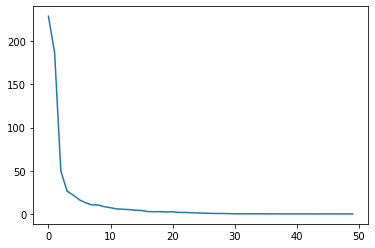

In [16]:
backprop_deep(x_train_torch, y_train_torch, net, T=50)

*COMPLETE*

## Question 15 - Optional

If you have a GPU, experiment the following and analyze the results

In [ ]:
import time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device is not 'cpu':
    net = LeNet().to(device)
    xtrain = xtrain.to(device)
    ltrain = ltrain.to(device)
    t = time.time()
    backprop_deep(xtrain, ltrain, net, T=50)
    print(time.time() - t)
    net = net.to('cpu')
    xtrain_torch = xtrain_torch.to('cpu')
    ltrain_torch = ltrain_torch.to('cpu')
else:
    print('Sorry no GPU')  

## Question 16

Analyse the results obtained by applying the network to the testing dataset. 

In [18]:
pred = net(x_test_torch)
_, pred_labels = pred.max(1)
print("Accuracy: " + str(100 * (y_test_torch == pred_labels).float().mean()))

Accuracy: tensor(97.2400)


*COMPLETE*

# PART 5 - Comparison and conclusion

## Question 9

Compare all results and conclude


*COMPLETE*